In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr, norm
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


In [2]:

path = "Student Insomnia and Educational Outcomes Dataset_version-3.csv"
df = pd.read_csv(path)
print(df.shape, df.columns.tolist()[:20])


(996, 17) ['Timestamp', '1. What is your year of study?', '2. What is your gender?', '3. How often do you have difficulty falling asleep at night?', '4. On average, how many hours of sleep do you get on a typical day?', '5. How often do you wake up during the night and have trouble falling back asleep?', '6. How would you rate the overall quality of your sleep?', '7. How often do you experience difficulty concentrating during lectures or studying due to lack of sleep?', '8. How often do you feel fatigued during the day, affecting your ability to study or attend classes?', '9. How often do you miss or skip classes due to sleep-related issues (e.g., insomnia, feeling tired)?', '10. How would you describe the impact of insufficient sleep on your ability to complete assignments and meet deadlines?', 'Phone_Use', 'Caffeine', 'Exercise', 'Stress', 'GPA', 'Sleep_Index']


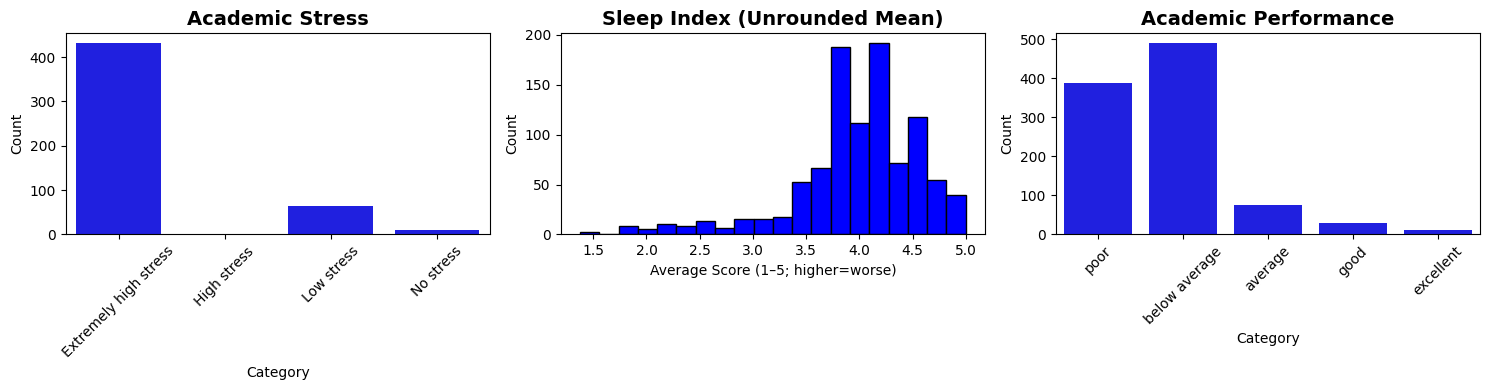

In [3]:
if 'Sleep_Index' not in df.columns:
    sleep_cols = [c for c in df.columns if c.lower().startswith('sleep_')]
    if sleep_cols:
        df['Sleep_Index'] = df[sleep_cols].mean(axis=1)

df['Stress'] = df['Stress'].astype(str).str.strip()
df['GPA'] = df['GPA'].astype(str).str.strip()

stress_map = {
    '4': "Extremely high stress",
    '3': "High stress",
    '2': "Low stress",
    '1': "No stress"
}
gpa_map = {
    '1': "poor",
    '2': "below average",
    '3': "average",
    '4': "good",
    '5': "excellent"
}

df['Stress'] = df['Stress'].replace(stress_map)
df['GPA'] = df['GPA'].replace(gpa_map)


stress_order = ["Extremely high stress", "High stress", "Low stress", "No stress"]
gpa_order = ["poor", "below average", "average", "good", "excellent"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(data=df, x='Stress', order=stress_order, color='blue', ax=axes[0])
axes[0].set_title("Academic Stress", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

axes[1].hist(df['Sleep_Index'].dropna(), bins=20, color='blue', edgecolor='black')
axes[1].set_title("Sleep Index (Unrounded Mean)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Average Score (1–5; higher=worse)")
axes[1].set_ylabel("Count")

sns.countplot(data=df, x='GPA', order=gpa_order, color='blue', ax=axes[2])
axes[2].set_title("Academic Performance", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Category")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.savefig("hist_combined.png", dpi=300)
plt.show()




In [4]:
path = "Student Insomnia and Educational Outcomes Dataset_version-3.csv"
df = pd.read_csv(path)
sleep_data = pd.to_numeric(df['Sleep_Index'], errors='coerce').dropna()
W, p_value = stats.shapiro(sleep_data)
norm_status = "Likely Normal" if p_value > 0.05 else "Not Normal"
print(f"Sleep_Index: W={W:.4f}, p={p_value:.6f} → {norm_status} (n={len(sleep_data)})")

Sleep_Index: W=0.9142, p=0.000000 → Not Normal (n=996)


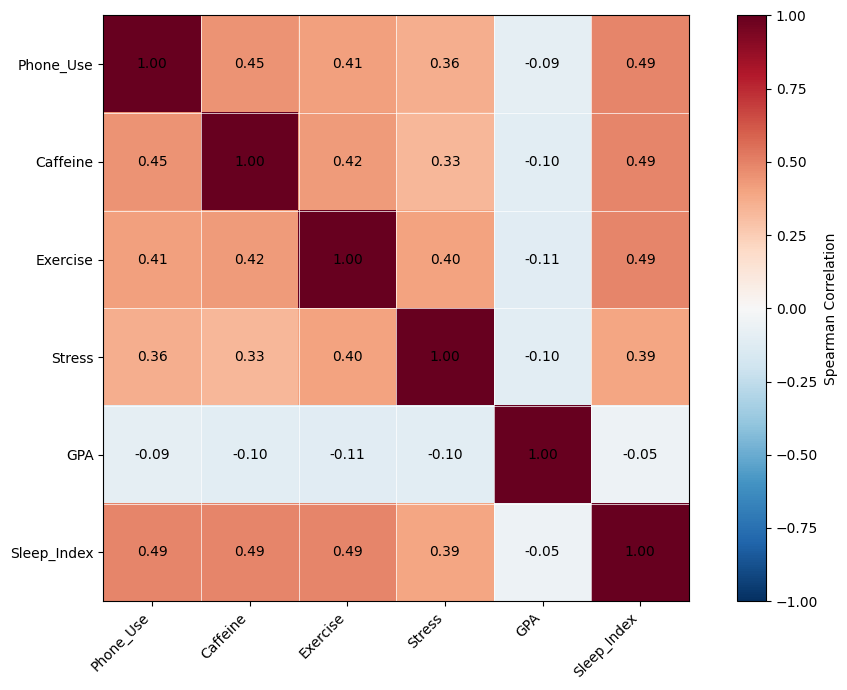

In [5]:
cols = ['Phone_Use', 'Caffeine', 'Exercise', 'Stress', 'GPA', 'Sleep_Index']

for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
corr = df[cols].corr(method='spearman')
fig = plt.figure(figsize=(10, 7))
ax = plt.gca()
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='RdBu_r')
ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticks(range(len(cols))); ax.set_yticklabels(cols)

ax.set_xticks(np.arange(-.5, len(cols), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(cols), 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

for i in range(len(cols)):
    for j in range(len(cols)):
        val = corr.values[i, j]
        ax.text(j, i, "" if np.isnan(val) else f"{val:.2f}", ha='center', va='center')

cb = fig.colorbar(im); cb.set_label("Spearman Correlation")
plt.tight_layout(); plt.show()




In [6]:
def effect_size_label(r):
    if r < 0.10:
        return "negligible"
    elif r < 0.30:
        return "small"
    elif r < 0.50:
        return "medium"
    else:
        return "large"

def mannwhitney_with_r(x, group, g1_label='Female', g2_label='Male'):
    mask1 = (group == g1_label) & x.notna()
    mask2 = (group == g2_label) & x.notna()
    x1, x2 = x[mask1], x[mask2]
    U, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
    n1, n2 = len(x1), len(x2)
    mu = n1 * n2 / 2
    sigma = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (U - mu) / sigma
    r = abs(z) / np.sqrt(n1 + n2)
    return U, p, r, effect_size_label(r), n1, n2

variables = ['Sleep_Index', 'Stress', 'GPA']
for var in variables:
    if var in df.columns:
        data = pd.to_numeric(df[var], errors='coerce')
        U, p, r, label, n1, n2 = mannwhitney_with_r(data, df['2. What is your gender?'])
        print(f"{var}: U={U:.1f}, p={p:.4g}, r={r:.3f} ({label} effect size), n1={n1}, n2={n2}")


Sleep_Index: U=92860.0, p=0.00269, r=0.095 (negligible effect size), n1=305, n2=691
Stress: U=99437.0, p=0.1123, r=0.045 (negligible effect size), n1=305, n2=691
GPA: U=114926.5, p=0.01177, r=0.072 (negligible effect size), n1=305, n2=691


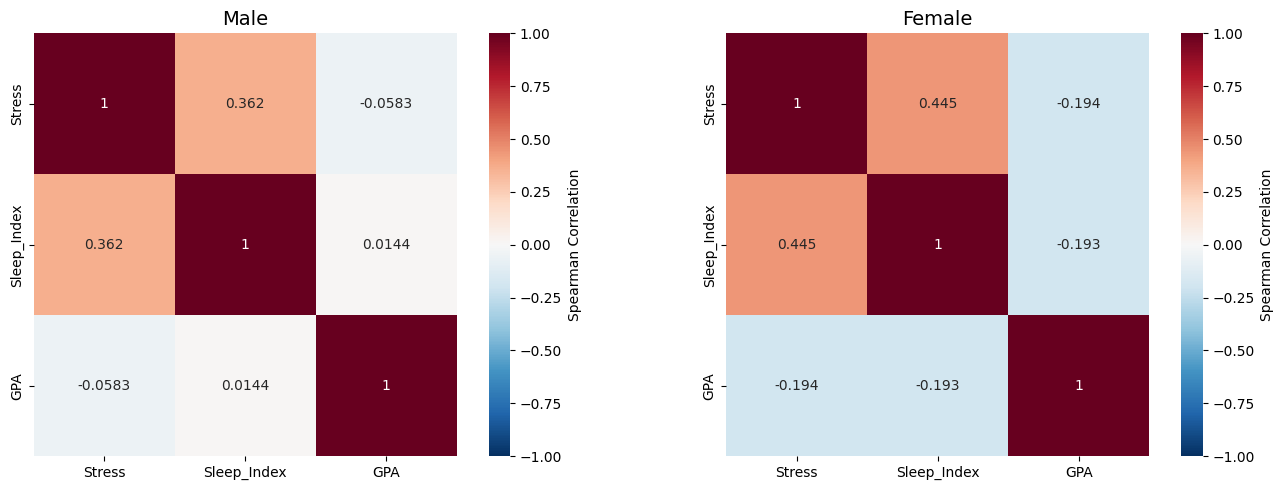

In [7]:
gender_col = '2. What is your gender?'
vars_of_interest = ['Stress', 'Sleep_Index', 'GPA']

for c in vars_of_interest:
    df[c] = pd.to_numeric(df[c], errors='coerce')

male_df = df[df[gender_col].str.strip().str.lower() == 'male'][vars_of_interest]
female_df = df[df[gender_col].str.strip().str.lower() == 'female'][vars_of_interest]
male_corr = male_df.corr(method='spearman')
female_corr = female_df.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(male_corr, vmin=-1, vmax=1, center=0,
            cmap='RdBu_r', annot=True, fmt=".3g", square=True,
            cbar_kws={"label": "Spearman Correlation"}, ax=axes[0])
axes[0].set_title("Male", fontsize=14)

sns.heatmap(female_corr, vmin=-1, vmax=1, center=0,
            cmap='RdBu_r', annot=True, fmt=".3g", square=True,
            cbar_kws={"label": "Spearman Correlation"}, ax=axes[1])
axes[1].set_title("Female", fontsize=14)

plt.tight_layout()
plt.show()


In [8]:
pairs = [
    ('Stress', 'Sleep_Index'),
    ('Stress', 'GPA'),
    ('Sleep_Index', 'GPA'),]

vars_flat = sorted(set([v for pair in pairs for v in pair]))
for c in vars_flat:
    df[c] = pd.to_numeric(df[c], errors='coerce')

def fisher_z_diff(r1, n1, r2, n2):
    r1 = np.clip(r1, -0.999999, 0.999999)
    r2 = np.clip(r2, -0.999999, 0.999999)
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2) / se
    p = 2 * norm.sf(abs(z))
    return float(z), float(p)

def corr_and_n(sub_df, a, b):
    tmp = sub_df[[a, b]].dropna()
    n = len(tmp)
    if n < 4:
        return np.nan, n
    r, _ = spearmanr(tmp[a], tmp[b])
    return float(r), n

male_mask   = df[gender_col].astype(str).str.strip().str.lower() == 'male'
female_mask = df[gender_col].astype(str).str.strip().str.lower() == 'female'

rows = []
for (a, b) in pairs:
    r_m, n_m = corr_and_n(df[male_mask], a, b)
    r_f, n_f = corr_and_n(df[female_mask], a, b)

    if np.isnan(r_m) or np.isnan(r_f) or n_m < 4 or n_f < 4:
        z, p = np.nan, np.nan
    else:
        z, p = fisher_z_diff(r_f, n_f, r_m, n_m)

    rows.append({
        'Pair': f'{a} ~ {b}',
        'r_male': r_m, 'n_male': n_m,
        'r_female': r_f, 'n_female': n_f,
        'Z (female - male)': z,
        'p_value (two-sided)': p,
        'Significant @ 0.05?': (p < 0.05) if pd.notna(p) else np.nan
    })

results = pd.DataFrame(rows)
with pd.option_context('display.float_format', '{:.4g}'.format):
    print(results)


                   Pair   r_male  n_male  r_female  n_female  \
0  Stress ~ Sleep_Index   0.3618     691    0.4452       305   
1          Stress ~ GPA -0.05826     691   -0.1935       305   
2     Sleep_Index ~ GPA  0.01445     691   -0.1928       305   

   Z (female - male)  p_value (two-sided)  Significant @ 0.05?  
0              1.446               0.1483                False  
1             -1.995               0.0461                 True  
2             -3.037             0.002386                 True  


In [9]:
year_col = "1. What is your year of study?"
def parse_year(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace('-', ' ').replace('_', ' ')
    if 'graduate' in s:
        return 5.0  # Graduate = מתקדם
    if 'first year'  in s: return 1.0
    if 'second year' in s: return 2.0
    if 'third year'  in s: return 3.0
    if 'fourth year' in s: return 4.0
    if 'fifth year'  in s: return 5.0
    mapping = {
        'first':1, '1st':1, 'year 1':1, 'one':1,
        'second':2,'2nd':2,'year 2':2,'two':2,
        'third':3, '3rd':3,'year 3':3,'three':3,
        'fourth':4,'4th':4,'year 4':4,'four':4,
        'fifth':5, '5th':5,'year 5':5,'five':5,
    }
    if s in mapping:
        return float(mapping[s])
    m = re.search(r'\b([1-6])\b', s)
    if m:
        return float(m.group(1))
    try:
        return float(s)
    except:
        return np.nan

df['Year_clean'] = df[year_col].apply(parse_year)
df['YearGroup']  = np.where(df['Year_clean'] <= 2, 'Early',
                     np.where(df['Year_clean'] >  2, 'Advanced', 'Unknown'))

for c in ['Sleep_Index', 'Stress', 'GPA']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

def mannwhitney_with_r(series, group):
    s = pd.to_numeric(series, errors='coerce')
    x1 = s[group == 'Early'].dropna()
    x2 = s[group == 'Advanced'].dropna()
    n1, n2 = len(x1), len(x2)
    if n1 < 3 or n2 < 3:
        return np.nan, np.nan, np.nan, n1, n2
    U, p = stats.mannwhitneyu(x1, x2, alternative='two-sided')
    mu    = n1 * n2 / 2
    sigma = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z     = (U - mu) / sigma
    r     = abs(z) / np.sqrt(n1 + n2)
    return U, p, r, n1, n2

def effect_size_label(r):
    if r < 0.10: return "negligible"
    if r < 0.30: return "small"
    if r < 0.50: return "medium"
    return "large"

for var in ['Sleep_Index', 'Stress', 'GPA']:
    if var in df.columns:
        U, p, r, n1, n2 = mannwhitney_with_r(df[var], df['YearGroup'])
        label = effect_size_label(r) if np.isfinite(r) else "—"
        print(f"{var}: U={U:.1f}, p={p:.5f}, r={r:.3f} ({label} effect size)")

Sleep_Index: U=21220.5, p=0.00000, r=0.260 (small effect size)
Stress: U=32319.5, p=0.00001, r=0.129 (small effect size)
GPA: U=48596.5, p=0.02620, r=0.064 (negligible effect size)


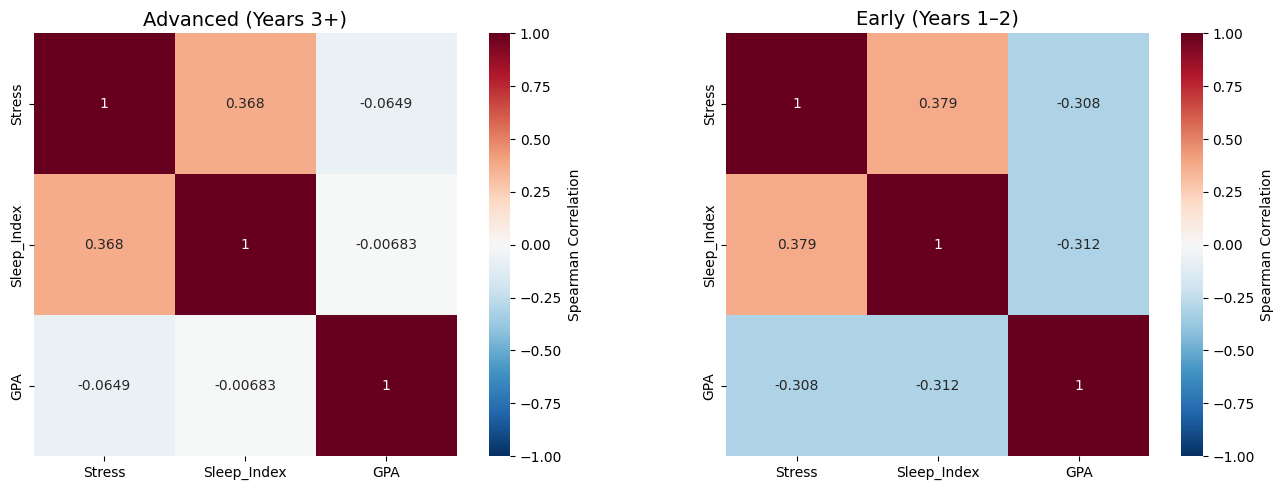

In [10]:
vars_of_interest = ['Stress', 'Sleep_Index', 'GPA']
for c in vars_of_interest:
    df[c] = pd.to_numeric(df[c], errors='coerce')
early_mask = df[year_col].astype(str).str.contains('First|Second', case=False, na=False)
adv_mask   = df[year_col].astype(str).str.contains('Third|Graduate', case=False, na=False)

early_df = df[early_mask][vars_of_interest]
adv_df   = df[adv_mask][vars_of_interest]

early_corr = early_df.corr(method='spearman')
adv_corr   = adv_df.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(adv_corr, vmin=-1, vmax=1, center=0,
            cmap='RdBu_r', annot=True, fmt=".3g", square=True,
            cbar_kws={"label": "Spearman Correlation"}, ax=axes[0])
axes[0].set_title("Advanced (Years 3+)", fontsize=14)

sns.heatmap(early_corr, vmin=-1, vmax=1, center=0,
            cmap='RdBu_r', annot=True, fmt=".3g", square=True,
            cbar_kws={"label": "Spearman Correlation"}, ax=axes[1])
axes[1].set_title("Early (Years 1–2)", fontsize=14)

plt.tight_layout()
plt.show()


In [11]:
pairs = [
    ('Stress', 'Sleep_Index'),
    ('Stress', 'GPA'),
    ('Sleep_Index', 'GPA'),
]

def fisher_z_diff(r1, n1, r2, n2):
    r1 = np.clip(r1, -0.999999, 0.999999)
    r2 = np.clip(r2, -0.999999, 0.999999)
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2) / se
    p = 2 * norm.sf(abs(z))
    return float(z), float(p)

def corr_and_n(sub_df, a, b):
    tmp = sub_df[[a, b]].dropna()
    n = len(tmp)
    if n < 4:
        return np.nan, n
    r, _ = spearmanr(tmp[a], tmp[b])
    return float(r), n

rows = []
for (a, b) in pairs:
    r_adv, n_adv = corr_and_n(adv_df, a, b)
    r_early, n_early = corr_and_n(early_df, a, b)

    if np.isnan(r_adv) or np.isnan(r_early):
        z, p = np.nan, np.nan
    else:
        z, p = fisher_z_diff(r_early, n_early, r_adv, n_adv)
    rows.append({
        'Pair': f'{a} ~ {b}',
        'r_advanced': r_adv, 'n_advanced': n_adv,
        'r_early': r_early, 'n_early': n_early,
        'Z (early - advanced)': z,
        'p_value': p,
        'Significant @ 0.05?': (p < 0.05) if p is not np.nan else np.nan
    })

results = pd.DataFrame(rows)
with pd.option_context('display.float_format', '{:.4g}'.format):
    print(results)


                   Pair  r_advanced  n_advanced  r_early  n_early  \
0  Stress ~ Sleep_Index      0.3683         900   0.3788       96   
1          Stress ~ GPA    -0.06494         900  -0.3079       96   
2     Sleep_Index ~ GPA   -0.006829         900  -0.3122       96   

   Z (early - advanced)  p_value  Significant @ 0.05?  
0                 0.112   0.9109                False  
1                -2.324  0.02011                 True  
2                -2.902 0.003712                 True  


In [12]:
SLEEP_COL  = 'Sleep_Index'
STRESS_COL = 'Stress'
GPA_COL    = 'GPA'
def to_numeric_smart(s):
    s = s.astype(str).str.strip()
    s = s.replace({'': np.nan, 'None': np.nan, 'nan': np.nan, 'NaN': np.nan, 'N/A': np.nan})
    s = s.str.replace(',', '.', regex=False)
    num = s.str.extract(r'([-+]?\d*\.?\d+)')[0]
    return pd.to_numeric(num, errors='coerce')

for c in [SLEEP_COL, STRESS_COL, GPA_COL]:
    df[c] = to_numeric_smart(df[c])

data = df[[SLEEP_COL, STRESS_COL, GPA_COL]].dropna().copy()

data_std = (data - data.mean()) / data.std(ddof=0)
X_sleep = sm.add_constant(data_std[[SLEEP_COL]])
X_stress = sm.add_constant(data_std[[STRESS_COL]])
X_both = sm.add_constant(data_std[[SLEEP_COL, STRESS_COL]])
y = data_std[GPA_COL]

def fit_and_extract(X, y):
    model = sm.OLS(y, X).fit()
    coefs = model.params
    pvals = model.pvalues
    return model, coefs, pvals


m1, b1, p1 = fit_and_extract(X_sleep, y)
m2, b2, p2 = fit_and_extract(X_both,  y)

m3, b3, p3 = fit_and_extract(X_stress, y)
m4, b4, p4 = fit_and_extract(X_both,  y)

def row(label, beta, p):
    return {'Predictor': label, 'Beta (std)': float(beta), 'p_value': float(p)}

res_sleep_path = pd.DataFrame([
    row('Sleep (alone)', b1[SLEEP_COL], p1[SLEEP_COL]),
    row('Sleep (with Stress)', b2[SLEEP_COL], p2[SLEEP_COL]),
    row('Stress (with Sleep)', b2[STRESS_COL], p2[STRESS_COL]),
])

res_stress_path = pd.DataFrame([
    row('Stress (alone)', b3[STRESS_COL], p3[STRESS_COL]),
    row('Stress (with Sleep)', b4[STRESS_COL], p4[STRESS_COL]),
    row('Sleep (with Stress)', b4[SLEEP_COL], p4[SLEEP_COL]),
])

print("\n=== (a) Sleep → Stress → GPA ===")
print(res_sleep_path.to_string(index=False))

print("\n=== (b) Stress → Sleep → GPA ===")
print(res_stress_path.to_string(index=False))

def partial_mediation_msg(beta_alone, beta_with_med):
    return "Partial mediation (|β| decreased)" if abs(beta_with_med) < abs(beta_alone) else "No reduction → no mediation evidence"

print("\nConclusion (a):", partial_mediation_msg(b1[SLEEP_COL], b2[SLEEP_COL]))
print("Conclusion (b):", partial_mediation_msg(b3[STRESS_COL], b4[STRESS_COL]))





=== (a) Sleep → Stress → GPA ===
          Predictor  Beta (std)  p_value
      Sleep (alone)     -0.2617   0.0000
Sleep (with Stress)     -0.1912   0.0000
Stress (with Sleep)     -0.1753   0.0000

=== (b) Stress → Sleep → GPA ===
          Predictor  Beta (std)  p_value
     Stress (alone)     -0.2522   0.0000
Stress (with Sleep)     -0.1753   0.0000
Sleep (with Stress)     -0.1912   0.0000

Conclusion (a): Partial mediation (|β| decreased)
Conclusion (b): Partial mediation (|β| decreased)


In [13]:
SLEEP_COL  = 'Sleep_Index'
STRESS_COL = 'Stress'
GPA_COL    = 'GPA'
GENDER_COL = '2. What is your gender?'
YEAR_COL   = '1. What is your year of study?'
def to_numeric_smart(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.replace({'': np.nan, 'None': np.nan, 'nan': np.nan, 'NaN': np.nan, 'N/A': np.nan})
    s = s.str.replace(',', '.', regex=False)
    num = s.str.extract(r'([-+]?\d*\.?\d+)')[0]
    return pd.to_numeric(num, errors='coerce')

for c in [SLEEP_COL, STRESS_COL, GPA_COL]:
    df[c] = to_numeric_smart(df[c])

df['Gender_cat'] = df[GENDER_COL].astype(str).str.strip().str.title()

valid_gender = df['Gender_cat'].isin(['Male', 'Female'])
df.loc[~valid_gender, 'Gender_cat'] = np.nan
df['Gender_cat'] = pd.Categorical(df['Gender_cat'], categories=['Female', 'Male'])

year = df[YEAR_COL].astype(str).str.strip()
early_mask = year.str.contains('First|Second', case=False, regex=True, na=False)
adv_mask   = year.str.contains('Third|Graduate', case=False, regex=True, na=False)

df['Year_cat'] = np.where(early_mask, 'Early',
                     np.where(adv_mask, 'Advanced', 'Unknown'))
df['Year_cat'] = pd.Categorical(df['Year_cat'], categories=['Advanced', 'Early', 'Unknown'])
base_cols = [SLEEP_COL, STRESS_COL, GPA_COL, 'Gender_cat', 'Year_cat']
work = df[base_cols].dropna().copy()


m1 = smf.ols(formula=f"{GPA_COL} ~ {SLEEP_COL} * {STRESS_COL}", data=work).fit()
m2 = smf.ols(
    formula=f"{GPA_COL} ~ {SLEEP_COL} * C(Gender_cat, Treatment(reference='Female')) + {STRESS_COL}",
    data=work
).fit()
m3 = smf.ols(
    formula=f"{GPA_COL} ~ {SLEEP_COL} * C(Year_cat, Treatment(reference='Advanced')) + {STRESS_COL}",
    data=work
).fit()

def p_for_interaction(model, term_prefix):
    p_series = model.pvalues
    hits = p_series[p_series.index.str.contains(term_prefix, regex=False)]
    if len(hits) == 0:
        hits = p_series[p_series.index.str.contains(SLEEP_COL + ":", regex=False)]
    return hits

p_m1 = p_for_interaction(m1, f"{SLEEP_COL}:{STRESS_COL}")
p_m2 = p_for_interaction(m2, f"{SLEEP_COL}:C(Gender_cat, Treatment(reference='Female'))")
p_m3 = p_for_interaction(m3, f"{SLEEP_COL}:C(Year_cat, Treatment(reference='Advanced'))")

def fmt_p(p):
    return f"{p:.4g}" if np.isfinite(p) else "NA"

print("H. Interaction Effects of Sleep Quality with Stress, Gender, and Year of Study\n")


if len(p_m1) >= 1:
    p1 = float(p_m1.iloc[0])
    print(f"Sleep_Index × Stress: p = {fmt_p(p1)}")
else:
    print("Sleep_Index × Stress: p = NA")

if len(p_m2) >= 1:
    if len(p_m2) == 1:
        p2 = float(p_m2.iloc[0])
        print(f"Sleep_Index × Gender: p = {fmt_p(p2)}  (Female ref)")
    else:
        print("Sleep_Index × Gender (Female ref) – interaction terms:")
        for name, val in p_m2.items():
            print(f"  {name}: p = {fmt_p(float(val))}")
else:
    print("Sleep_Index × Gender: p = NA")
if len(p_m3) >= 1:
    if len(p_m3) == 1:
        p3 = float(p_m3.iloc[0])
        print(f"Sleep_Index × Year: p = {fmt_p(p3)}  (Advanced ref)")
    else:
        print("Sleep_Index × Year (Advanced ref) – interaction terms:")
        for name, val in p_m3.items():
            print(f"  {name}: p = {fmt_p(float(val))}")
else:
    print("Sleep_Index × Year: p = NA")

H. Interaction Effects of Sleep Quality with Stress, Gender, and Year of Study

Sleep_Index × Stress: p = 3.731e-11
Sleep_Index × Gender: p = 3.57e-05  (Female ref)
Sleep_Index × Year (Advanced ref) – interaction terms:
  Sleep_Index:C(Year_cat, Treatment(reference='Advanced'))[T.Early]: p = 0.0757
  Sleep_Index:C(Year_cat, Treatment(reference='Advanced'))[T.Unknown]: p = NA


In [14]:
def to_numeric_smart(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.replace({'': np.nan, 'None': np.nan, 'nan': np.nan, 'NaN': np.nan, 'N/A': np.nan})
    s = s.str.replace(',', '.', regex=False)
    num = s.str.extract(r'([-+]?\d*\.?\d+)')[0]
    return pd.to_numeric(num, errors='coerce')

for c in [SLEEP_COL, STRESS_COL, GPA_COL]:
    df[c] = to_numeric_smart(df[c])
df['Gender_cat'] = df[GENDER_COL].astype(str).str.strip().str.title()
valid_gender = df['Gender_cat'].isin(['Male', 'Female'])
df.loc[~valid_gender, 'Gender_cat'] = np.nan
df['Gender_cat'] = pd.Categorical(df['Gender_cat'], categories=['Female', 'Male'])

year = df[YEAR_COL].astype(str).str.strip()
early_mask = year.str.contains('First|Second', case=False, regex=True, na=False)
adv_mask   = year.str.contains('Third|Graduate', case=False, regex=True, na=False)

df['Year_cat'] = np.where(early_mask, 'Early',
                   np.where(adv_mask, 'Advanced', 'Unknown'))

df['Year_cat'] = pd.Categorical(df['Year_cat'], categories=['Advanced', 'Early', 'Unknown'])

base_cols = [SLEEP_COL, STRESS_COL, GPA_COL, 'Gender_cat', 'Year_cat']
work = df[base_cols].dropna().copy()


m1 = smf.ols(formula=f"{GPA_COL} ~ {STRESS_COL} * {SLEEP_COL}", data=work).fit()

m2 = smf.ols(
    formula=f"{GPA_COL} ~ {STRESS_COL} * C(Gender_cat, Treatment(reference='Female')) + {SLEEP_COL}",
    data=work
).fit()

m3 = smf.ols(
    formula=f"{GPA_COL} ~ {STRESS_COL} * C(Year_cat, Treatment(reference='Advanced')) + {SLEEP_COL}",
    data=work
).fit()

def p_for_interaction(model, term_prefix):
    p_series = model.pvalues
    hits = p_series[p_series.index.str.contains(term_prefix, regex=False)]
    if len(hits) == 0:
        hits = p_series[p_series.index.str.contains(STRESS_COL + ":", regex=False)]
    return hits
p_m1 = p_for_interaction(m1, f"{STRESS_COL}:{SLEEP_COL}")

p_m2 = p_for_interaction(m2, f"{STRESS_COL}:C(Gender_cat, Treatment(reference='Female'))")
p_m3 = p_for_interaction(m3, f"{STRESS_COL}:C(Year_cat, Treatment(reference='Advanced'))")

def fmt_p(p):
    return f"{p:.4g}" if np.isfinite(p) else "NA"

print("I. Interaction Effects of Stress with Sleep Quality, Gender, and Year Group\n")

p1 = float(p_m1.iloc[0]) if len(p_m1) else np.nan
print(f"Stress × Sleep_Index: p = {fmt_p(p1)}")
if len(p_m2) >= 1:
    if len(p_m2) == 1:
        p2 = float(p_m2.iloc[0])
        print(f"Stress × Gender: p = {fmt_p(p2)}  (Female ref)")
    else:
        print("Stress × Gender (Female ref) – interaction terms:")
        for name, val in p_m2.items():
            print(f"  {name}: p = {fmt_p(float(val))}")
else:
    print("Stress × Gender: p = NA")
if len(p_m3) >= 1:
    if len(p_m3) == 1:
        p3 = float(p_m3.iloc[0])
        print(f"Stress × Year: p = {fmt_p(p3)}  (Advanced ref)")
    else:
        print("Stress × Year (Advanced ref) – interaction terms:")
        for name, val in p_m3.items():
            print(f"  {name}: p = {fmt_p(float(val))}")
else:
    print("Stress × Year: p = NA")


I. Interaction Effects of Stress with Sleep Quality, Gender, and Year Group

Stress × Sleep_Index: p = 3.731e-11
Stress × Gender: p = 0.01523  (Female ref)
Stress × Year (Advanced ref) – interaction terms:
  Stress:C(Year_cat, Treatment(reference='Advanced'))[T.Early]: p = 0.09643
  Stress:C(Year_cat, Treatment(reference='Advanced'))[T.Unknown]: p = NA
